# Precipitation Forecasting using CNN-LSTM

In this Notebook, we investigate a hybrid Convolutional Neural Network (CNN) and Long Short-Term Memory (LSTM) model to forecast precipitation. CNN-LSTM models combine the strengths of both CNNs and LSTMs to capture feature internal and temporal dependencies in sequential data. CNNs are useful for extracting local patterns and features from data through convolutional operations, while LSTMs are specialized recurrent neural networks designed to capture long-term dependencies by maintaining internal memory across sequential inputs. This combination allows the model to effectively learn complex patterns in weather data, where both relationships inbetween the features and temporal information are crucial for accurate forecasting.

## 0. Imports and Basic Setup

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout

## 1. Load Preprocessed Train, Validation, and Test Splits


In [2]:
train_data = pd.read_csv("../data/processed/train_data.csv")
validation_data = pd.read_csv("../data/processed/validation_data.csv")
test_data = pd.read_csv("../data/processed/test_data.csv")

# Sort splits by location -> YYYY -> DOY to ensure correct time ordering
train_data.sort_values(by=["location", "YYYY", "DOY"], inplace=True)
validation_data.sort_values(by=["location", "YYYY", "DOY"], inplace=True)
test_data.sort_values(by=["location", "YYYY", "DOY"], inplace=True)

## 2. Create Sequences for LSTM

This function, which was also used for the RNN creates for each partition (train/val/test) sequences of length *seq_length* to predict *prec* on the "next" day. For example, X[t : t+seq_length] -> y[t+seq_length].

Important: Because data comes from multiple locations, the simplest approach is to do it location by location to avoid "splicing" between location boundaries. 

In [3]:
def create_sequences(df, feature_cols, target_col, seq_length=30):
    """
    For each location independently, create sequences of length seq_length
    to predict the (seq_length+1)-th day's target_col.
    Returns:
        X: np.array of shape (num_samples, seq_length, num_features)
        y: np.array of shape (num_samples,)
    """
    X_list, y_list = [], []
    
    # Group by location so we don't mix data across different basins
    grouped = df.groupby("location", group_keys=True)
    
    for loc, loc_df in grouped:
        loc_df = loc_df.reset_index(drop=True)  # reindex after grouping

        # Convert to numpy for slicing
        loc_features = loc_df[feature_cols].values
        loc_target = loc_df[target_col].values

        # Slide over the time dimension for that location
        for i in range(len(loc_df) - seq_length):
            X_list.append(loc_features[i : i + seq_length])
            y_list.append(loc_target[i + seq_length])

    X_arr = np.array(X_list)
    y_arr = np.array(y_list)
    return X_arr, y_arr

## 3. Define Features and Target

The target variable is "prec", while *all other numeric columns* from the preprocessed data are treated as potential features, except for location / date info.

In [4]:
exclude_cols = ["location", "YYYY", "DOY", "MM", "DD"]
feature_cols = [col for col in train_data.columns if col not in exclude_cols]
target_col = "prec"

print("Feature columns:", feature_cols)
print("Target column:", target_col)

Feature columns: ['2m_temp_max', '2m_temp_mean', '2m_temp_min', '2m_dp_temp_max', '2m_dp_temp_mean', '2m_dp_temp_min', '10m_wind_u', '10m_wind_v', 'fcst_alb', 'lai_high_veg', 'lai_low_veg', 'swe', 'surf_net_solar_rad_max', 'surf_net_solar_rad_mean', 'surf_net_therm_rad_max', 'surf_net_therm_rad_mean', 'surf_press', 'total_et', 'prec', 'volsw_123', 'volsw_4']
Target column: prec


## 4. Generate Sequence Datasets


In [5]:
SEQ_LENGTH = 30

X_train, y_train = create_sequences(train_data, feature_cols, target_col, seq_length=SEQ_LENGTH)
X_val, y_val = create_sequences(validation_data, feature_cols, target_col, seq_length=SEQ_LENGTH)
X_test, y_test = create_sequences(test_data, feature_cols, target_col, seq_length=SEQ_LENGTH)

print("Train sequence shape:", X_train.shape, y_train.shape)
print("Validation sequence shape:", X_val.shape, y_val.shape)
print("Test sequence shape:", X_test.shape, y_test.shape)

Train sequence shape: (1202300, 30, 21) (1202300,)
Validation sequence shape: (106600, 30, 21) (106600,)
Test sequence shape: (106500, 30, 21) (106500,)


## 5. Build a CNN-LSTM Model in Keras

Now we will create a CNN-LSTM Model. Therefore, we start with a simple Convolutional Layer, which is then followed by a LSTM layer. Additionally, we add a dropout layer inbetween for regularization and to prevent overfitting.

In [6]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(SEQ_LENGTH, len(feature_cols))))
model.add(Dropout(0.2))
model.add(LSTM(units=50, activation='relu', return_sequences=False))
model.add(Dense(units=1))

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

model.summary()

c:\Users\jogip\OneDrive - TU Wien\Master\AI ML in the era of Climate Change\AMITECC_Ex2\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 28, 32)         │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 50)             │        16,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,699 (73.04 KB)

 Trainable params: 18,699 (73.04 KB)

 Non-trainable params: 0 (0.00 B)

## 6. Train the Model

In [7]:
BATCH_SIZE = 256
EPOCHS = 10

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

Epoch 1/10
4697/4697 ━━━━━━━━━━━━━━━━━━━━ 212s 44ms/step - loss: 0.8303 - mae: 0.5727 - val_loss: 0.8220 - val_mae: 0.5567
Epoch 2/10
4697/4697 ━━━━━━━━━━━━━━━━━━━━ 157s 33ms/step - loss: 0.7706 - mae: 0.5434 - val_loss: 0.8142 - val_mae: 0.5735
Epoch 3/10
4697/4697 ━━━━━━━━━━━━━━━━━━━━ 153s 33ms/step - loss: 0.7454 - mae: 0.5364 - val_loss: 0.8236 - val_mae: 0.5647
Epoch 4/10
4697/4697 ━━━━━━━━━━━━━━━━━━━━ 155s 33ms/step - loss: 0.7304 - mae: 0.5312 - val_loss: 0.8346 - val_mae: 0.5762
Epoch 5/10
4697/4697 ━━━━━━━━━━━━━━━━━━━━ 155s 33ms/step - loss: 0.7115 - mae: 0.5263 - val_loss: 0.8335 - val_mae: 0.5527
Epoch 6/10
4697/4697 ━━━━━━━━━━━━━━━━━━━━ 154s 33ms/step - loss: 0.6949 - mae: 0.5228 - val_loss: 0.8272 - val_mae: 0.5682
Epoch 7/10
4697/4697 ━━━━━━━━━━━━━━━━━━━━ 156s 33ms/step - loss: 0.6911 - mae: 0.5204 - val_loss: 0.8351 - val_mae: 0.5727
Epoch 8/10
4697/4697 ━━━━━━━━━━━━━━━━━━━━ 153s 33ms/step - loss: 0.6741 - mae: 0.5153 - val_loss: 0.8408 - val_mae: 0.5723
Epoch 9/10
4697/

## 7. Evaluate the Model

In [8]:
val_preds = model.predict(X_val)
val_mse = mean_squared_error(y_val, val_preds)
val_rmse = np.sqrt(val_mse)
val_mae = mean_absolute_error(y_val, val_preds)

print(f"Validation MSE:  {val_mse:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")
print(f"Validation MAE:  {val_mae:.4f}")

# Evaluate on test set
test_preds = model.predict(X_test)
test_mse = mean_squared_error(y_test, test_preds)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, test_preds)

print(f"Test MSE:  {test_mse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE:  {test_mae:.4f}")

3332/3332 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step
Validation MSE:  0.8523
Validation RMSE: 0.9232
Validation MAE:  0.5686
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step
Test MSE:  0.8122
Test RMSE: 0.9012
Test MAE:  0.5693


## 8. Plot Training History

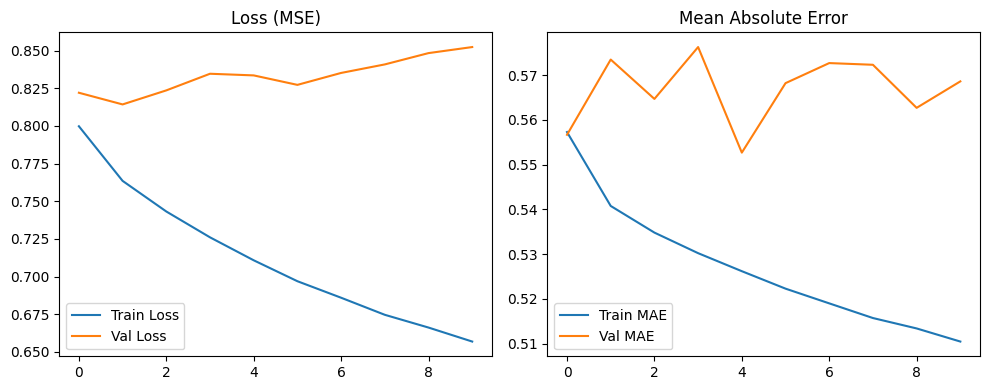

In [9]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss (MSE)")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title("Mean Absolute Error")
plt.legend()

plt.tight_layout()
plt.show()

## 9. Quick Prediction Visualization


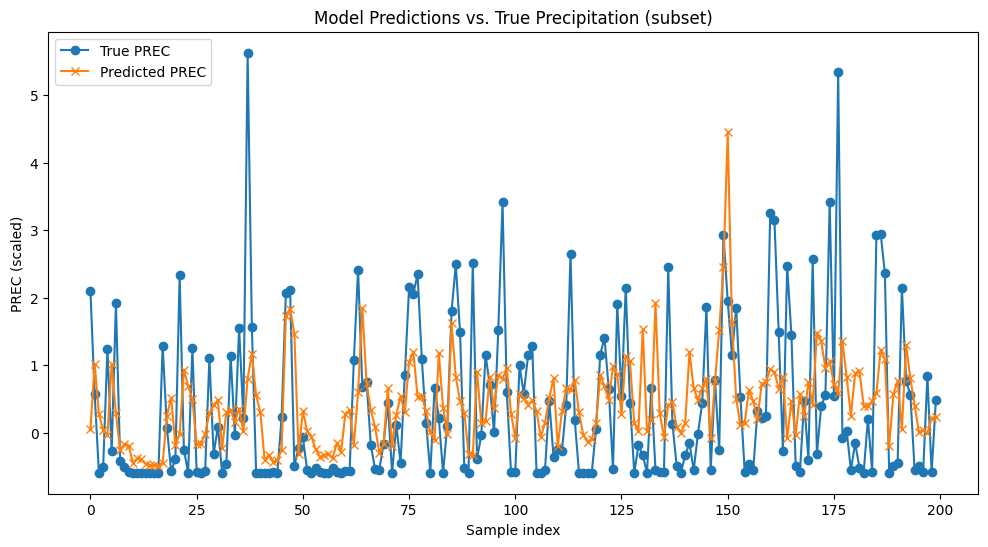

In [10]:
num_samples_to_plot = 200  # just pick some small subset 
plt.figure(figsize=(12,6))
plt.plot(y_test[:num_samples_to_plot], label='True PREC', marker='o')
plt.plot(test_preds[:num_samples_to_plot], label='Predicted PREC', marker='x')
plt.title("Model Predictions vs. True Precipitation (subset)")
plt.xlabel("Sample index")
plt.ylabel("PREC (scaled)")
plt.legend()
plt.show()

## 10. Feature Importance Study

To investigate feature importance in the CNN-LSTM, we use the same permutation importance approach as for the RNN model.

The idea is to:
* Compute a baseline metric (e.g. MSE) using the unshuffled test data.
* For each feature in the input set, shuffle (i.e. randomly permute) just that one feature across all test samples (keeping other features intact).
* Run inference on this shuffled data and measure the new metric.
* The increase in error (Δ MSE) compared to the baseline is treated as an indicator of that feature’s importance.

This approach is model-agnostic and commonly used for neural networks such as RNNs, but also LSTMs or CNNs.

3329/3329 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step
Baseline Test MSE: 0.8122
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 45s 14ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 47s 14ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 53s 16ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 52s 16ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 48s 14ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 47s 14ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 49s 15ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 53s 16ms/ste

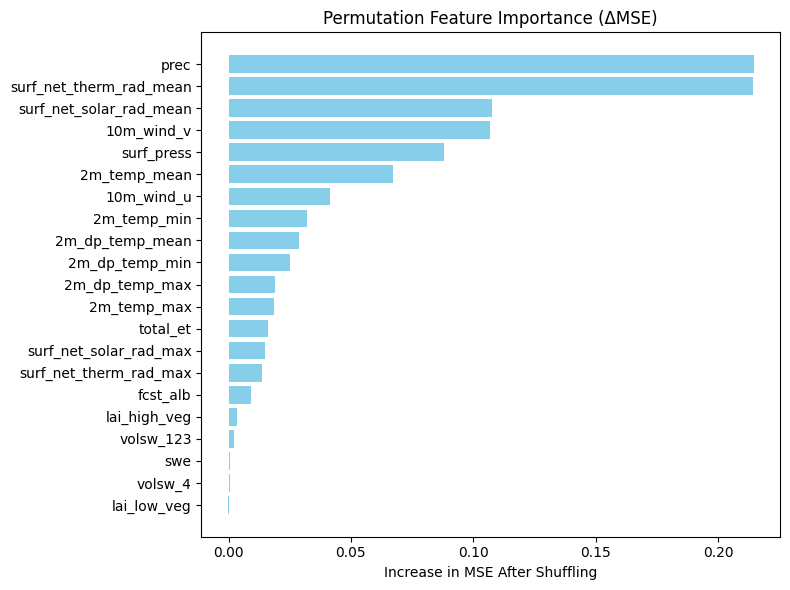

In [11]:
baseline_preds = model.predict(X_test)
baseline_mse = mean_squared_error(y_test, baseline_preds)
print(f"Baseline Test MSE: {baseline_mse:.4f}")

def permutation_importance(model, X, y, baseline_mse):
    """
    For each feature, shuffle it across the dataset, compute new MSE, 
    and measure the difference from baseline_mse. 
    Returns:
       dict { feature_name: delta_mse }
    """
    feature_importances = {}
    X_copy = np.copy(X) 
    
    num_features = X.shape[-1]  # last dimension = number of features
    for f_idx in range(num_features):
        # Shuffle only the f_idx-th feature
        shuffled = np.copy(X_copy)
        np.random.shuffle(shuffled[:, :, f_idx])  # shuffle in-place across the sample dimension
        
        # Predict with the permuted data
        perm_preds = model.predict(shuffled)
        perm_mse = mean_squared_error(y, perm_preds)
        
        delta_mse = perm_mse - baseline_mse
        feature_name = feature_cols[f_idx]
        feature_importances[feature_name] = delta_mse
    
    return feature_importances

importances_dict = permutation_importance(model, X_test, y_test, baseline_mse)

sorted_importances = sorted(importances_dict.items(), key=lambda x: x[1], reverse=True)
print("Feature Importances (Permutation-based), sorted by ΔMSE:")
for feat, imp in sorted_importances:
    print(f"Feature: {feat:<30} | ΔMSE: {imp:.6f}")

plt.figure(figsize=(8, 6))
feat_names = [x[0] for x in sorted_importances]
deltas = [x[1] for x in sorted_importances]
plt.barh(feat_names, deltas, color='skyblue')
plt.title("Permutation Feature Importance (ΔMSE)")
plt.xlabel("Increase in MSE After Shuffling")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()